In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

data = pd.read_csv("data\Steel_industry_data.csv")
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


### Checking the number of rows and columns

In [52]:
data.shape

(35040, 11)

### Information about the data

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Checking missing values

In [54]:
data.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

### Identify duplicates

In [55]:
dups = data.duplicated()
data[dups]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Identify mistyped data

Check numeric

In [56]:
numeric = data.applymap(lambda x: isinstance(x, (int, float)))['Usage_kWh']
data[~numeric]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


Check string

In [57]:
strings = data.applymap(lambda x: isinstance(x, (str)))['Day_of_week']
data[~strings]

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type


### Columns info

Column 'WeekStatus' values:

In [58]:
data['WeekStatus'].value_counts()

Weekday    25056
Weekend     9984
Name: WeekStatus, dtype: int64

Column 'Load_Type' values:

In [59]:
data['Load_Type'].value_counts()

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: Load_Type, dtype: int64

Mean value

In [60]:
data.mean(numeric_only=True)

Usage_kWh                                  27.386892
Lagging_Current_Reactive.Power_kVarh       13.035384
Leading_Current_Reactive_Power_kVarh        3.870949
CO2(tCO2)                                   0.011524
Lagging_Current_Power_Factor               80.578056
Leading_Current_Power_Factor               84.367870
NSM                                     42750.000000
dtype: float64

Median value

In [61]:
data.median(numeric_only=True)

Usage_kWh                                   4.57
Lagging_Current_Reactive.Power_kVarh        5.00
Leading_Current_Reactive_Power_kVarh        0.00
CO2(tCO2)                                   0.00
Lagging_Current_Power_Factor               87.96
Leading_Current_Power_Factor              100.00
NSM                                     42750.00
dtype: float64

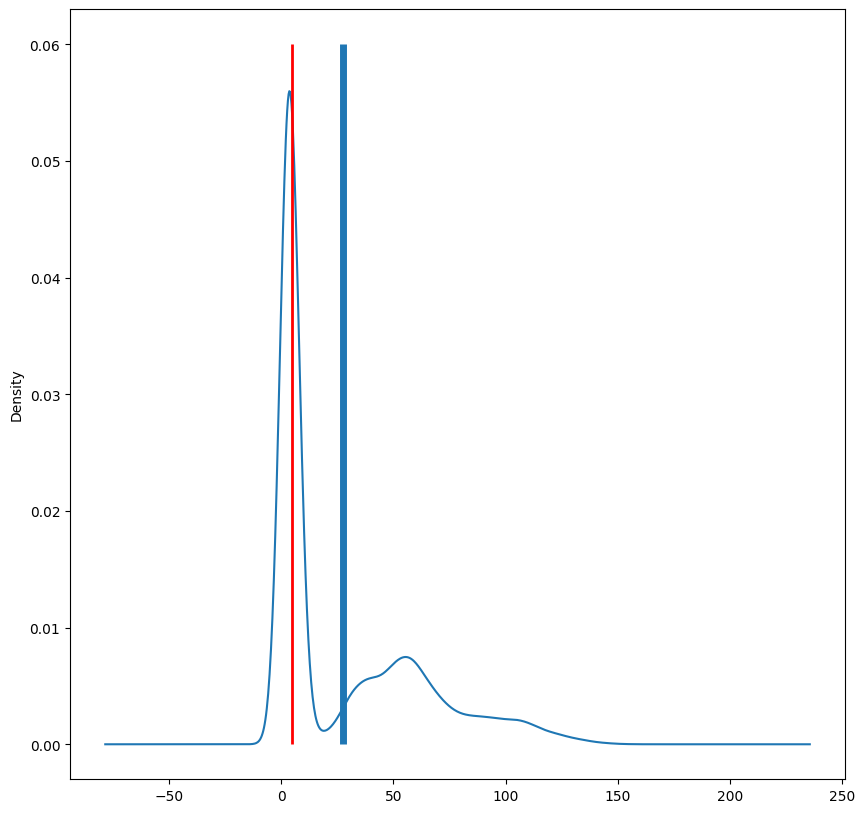

In [62]:
data['Usage_kWh'].plot(kind="density", figsize=(10,10))
plt.vlines(data['Usage_kWh'].mean(), ymin = 0, ymax = 0.06, linewidth = 5.0)
plt.vlines(data['Usage_kWh'].median(), ymin=0, ymax=0.06, linewidth=2.0, color="red")

Mode value

In [63]:
data.mode()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:00,3.06,0.0,0.0,0.0,100.0,100.0,0.0,Weekday,Monday,Light_Load
1,01/01/2018 00:15,NaN,NaN,NaN,NaN,NaN,NaN,900.0,NaN,NaN,NaN
2,01/01/2018 00:30,NaN,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN
3,01/01/2018 00:45,NaN,NaN,NaN,NaN,NaN,NaN,2700.0,NaN,NaN,NaN
4,01/01/2018 01:00,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35036,31/12/2018 23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35037,31/12/2018 23:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35038,31/12/2018 23:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Variance

In [64]:
data['Usage_kWh'].var()

1118.5265340538938

Standard deviation

In [65]:
data['Usage_kWh'].std()

33.44437970801513

Percentiles

In [66]:
percentiles = np.percentile(data['Usage_kWh'], [0, 25, 50, 75, 100])
percentiles

array([  0.    ,   3.2   ,   4.57  ,  51.2375, 157.18  ])

'Usage_kWh' column description:

In [67]:
desc_stat = scipy.stats.describe(data['Usage_kWh'], ddof = 1, bias = False)
desc_stat

DescribeResult(nobs=35040, minmax=(0.0, 157.18), mean=27.386892408675795, variance=1118.526534053894, skewness=1.1973938227692211, kurtosis=0.3913856014239281)

Data description

In [68]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


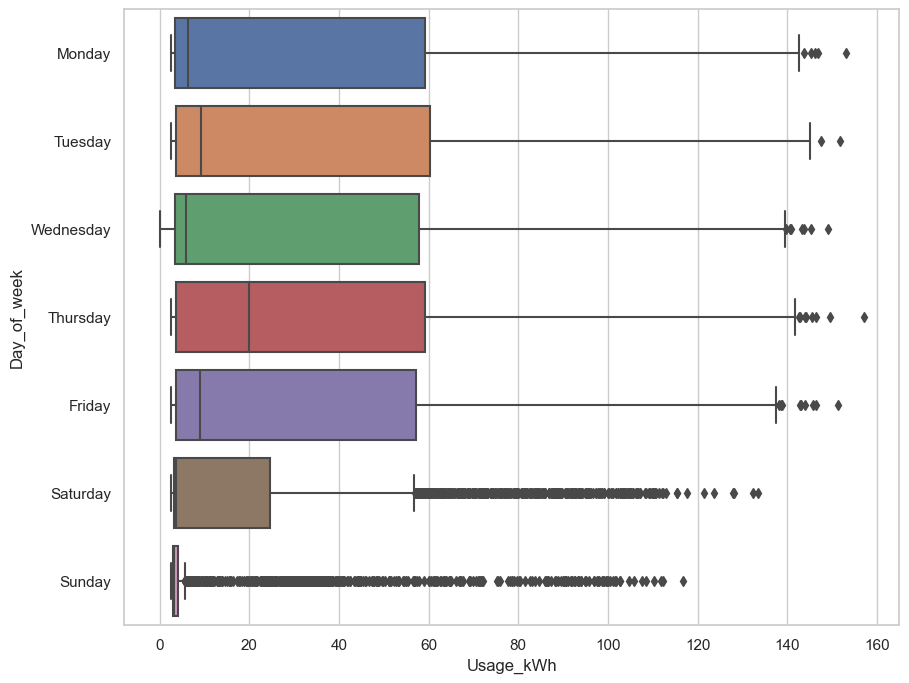

In [69]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Usage_kWh', data=data, y='Day_of_week', orient="h")

C:\Users\Tea\AppData\Local\Temp\ipykernel_5140\1477773921.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<AxesSubplot: >

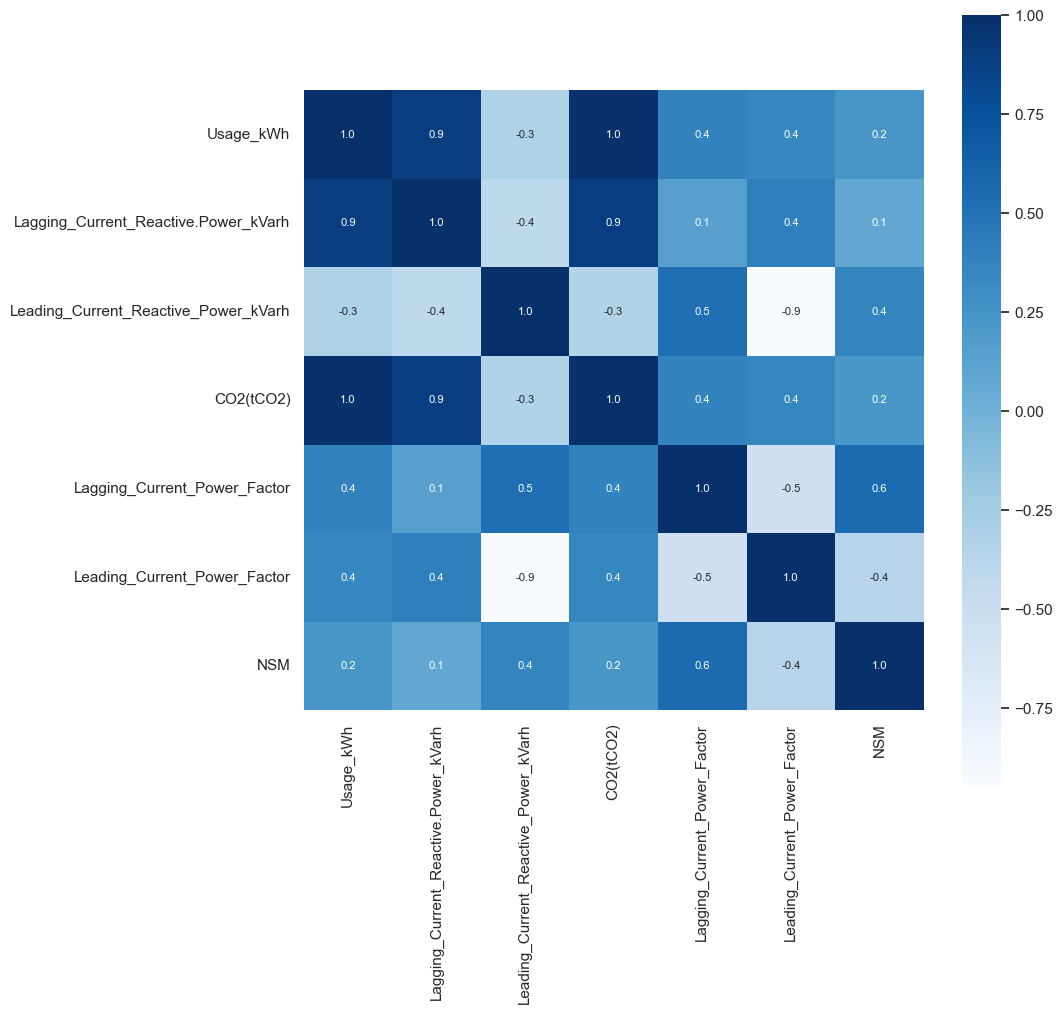

In [70]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')


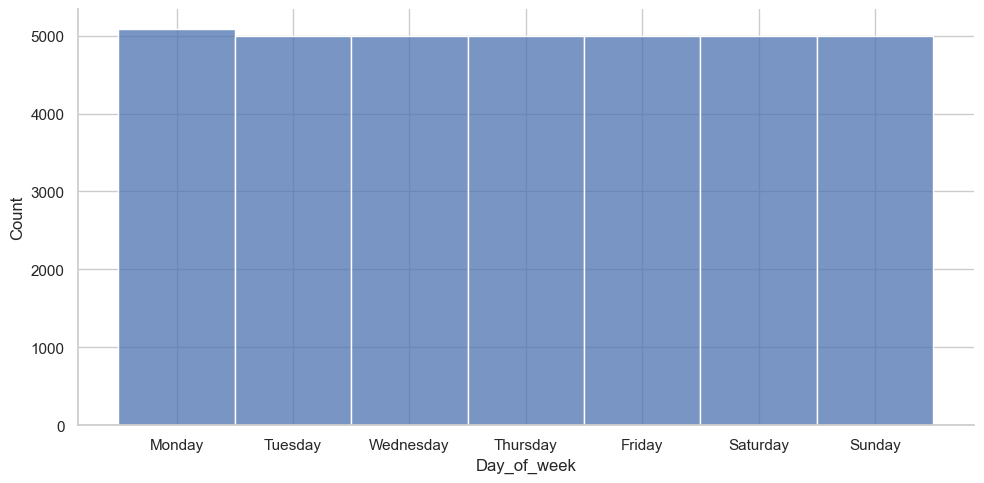

In [71]:
sns.displot(data['Day_of_week'], height=5, aspect=2)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b918ec4700>,
 'caps': [<matplotlib.lines.Line2D at 0x2b918ec4c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b918ec4460>,
 'medians': [<matplotlib.lines.Line2D at 0x2b918ec5180>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b918e2ead0>,
 'means': []}

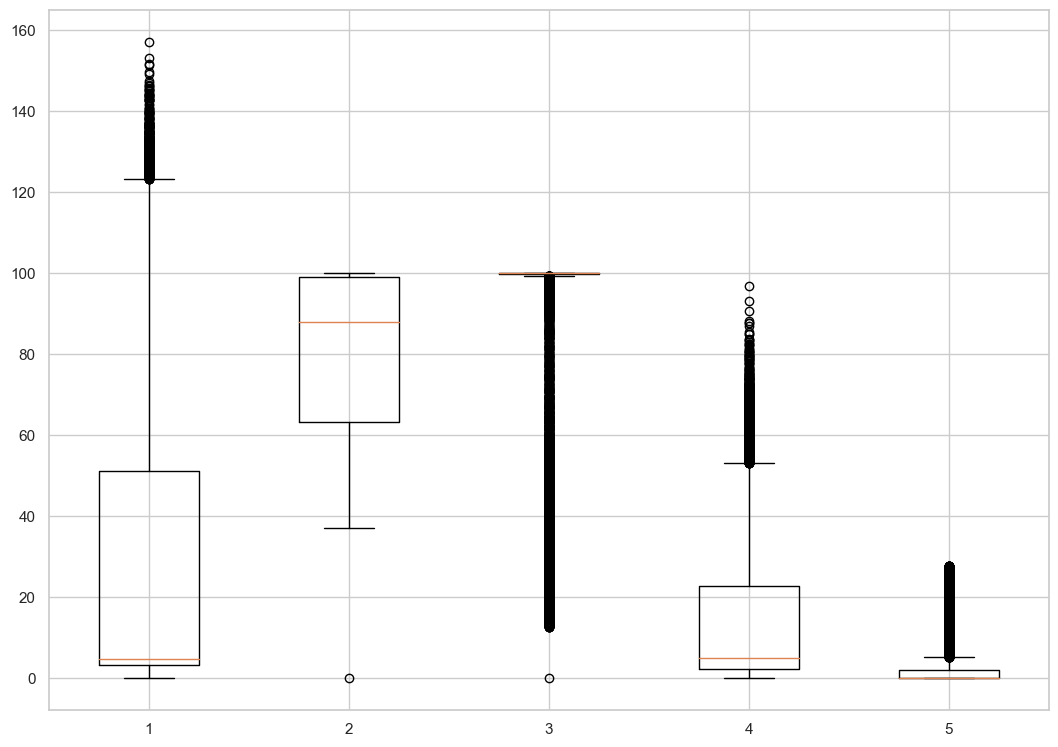

In [72]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([data['Usage_kWh'], data['Lagging_Current_Power_Factor'], data['Leading_Current_Power_Factor'], data['Lagging_Current_Reactive.Power_kVarh'], data['Leading_Current_Reactive_Power_kVarh']])